<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw2/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement various autoencoder models and run them on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code. It may take longer to run since we are using larger datasets.

In [1]:
# !if [ -d deepul ]; then rm -Rf deepul; fi
# !git clone https://github.com/rll/deepul.git
# !curl "https://drive.usercontent.google.com/download?id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF&confirm=xxx" -o hw2_data.zip
# !unzip -qq hw2_data.zip -d deepul/homeworks/hw2/data
# !pip install ./deepul
from deepul.hw2_helper import *

# Question 1: VAEs on 2D Data [20pts]
In this question, you will train a simple VAE on 2D data, and look at situations in which latents are being used or not being used (i.e. when posterior collapse occurs)

## Part (a) Data from a Full Covariance Gaussian [10 pts]
In this part, we train a VAE on data generated from a Gaussian with a full covariance matrix. Execute the cell below to visualize the datasets.

Dataset 1


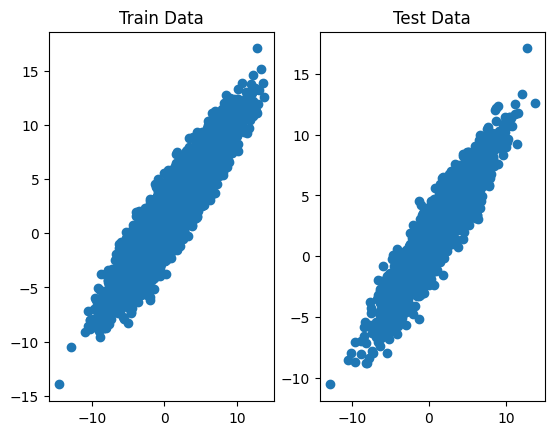

Dataset 2


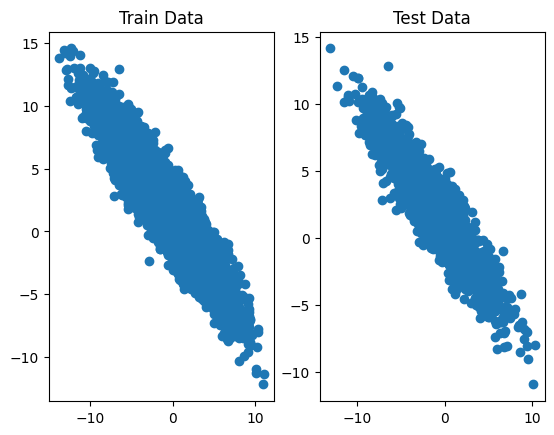

In [2]:
visualize_q1_data('a', 1)
visualize_q1_data('a', 2)

Consruct and train a VAE with the following characteristics
*   2D latent variables $z$ with a standard normal prior, $p(z) = N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), \Sigma_\phi(z))$, where $\mu_\phi(z)$ is the mean vector, and $\Sigma_\phi(z)$ is a diagonal covariance matrix

**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss $E_xE_{z\sim q(z|x)}[-p(x|z)]$, and KL term $E_x[D_{KL}(q(z|x)||p(z))]$ of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. Samples of your trained VAE with ($z\sim p(z), x\sim N(x;\mu_\phi(z),\Sigma_\phi(z))$) and without ($z\sim p(z), x = \mu_\phi(z)$) decoder noise




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [2]:
def train(model, train_loader, optimizer, grad_clip=None):
    model.train()
    train_losses = []
    for x in train_loader:
        loss = model.loss(x)
        elbo = loss[0]
        optimizer.zero_grad()
        elbo.backward()
        if grad_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        train_losses.append([loss[0].cpu().item(), loss[1].cpu().item(), loss[2].cpu().item()])
    return train_losses


def eval_loss(model, data_loader):
    model.eval()
    total_elbo = 0
    total_reconstruction = 0
    total_kl = 0
    for x in data_loader:
        with torch.no_grad():
            loss = model.loss(x)
            total_elbo += loss[0].cpu().item() * x.shape[0]
            total_reconstruction += loss[1].cpu().item() * x.shape[0]
            total_kl += loss[2].cpu().item() * x.shape[0]
    avg_elbo = total_elbo / len(data_loader.dataset)
    avg_reconstruction = total_reconstruction / len(data_loader.dataset)
    avg_kl = total_kl / len(data_loader.dataset)

    return [avg_elbo, avg_reconstruction, avg_kl]


def train_epochs(model, train_loader, test_loader, train_args, best_model=None):
    epochs, lr = train_args['epochs'], train_args['lr']
    grad_clip = train_args.get('grad_clip', None)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_loss = 1e8
    test_losses = [eval_loss(model, test_loader)]
    train_losses = []
    # test_losses = [[0, 0, 0]]
    # train_losses = [[0, 0, 0]]
    for epoch in range(epochs):
        train_losses.extend(train(model, train_loader, optimizer, grad_clip))
        test_losses.append(eval_loss(model, test_loader))
        if test_losses[-1][0] < best_loss:
            best_loss = test_losses[-1][0]
            best_model.load_state_dict(model.state_dict())
        print(f'Epoch {epoch}, ELBO {test_losses[-1][0]:.4f}')
    return train_losses, test_losses

In [3]:
import torch
from torch.distributions.normal import Normal
from torch import nn

class VAE(nn.Module):
    def __init__(self, sample_num, encoder_units, decoder_units):
        super().__init__()
        self.sample_num = sample_num
        self.data_dim = encoder_units[0]
        self.latent_dim = decoder_units[0]
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        encoder = []
        for i in range(len(encoder_units) - 1):
            encoder.append(nn.Linear(encoder_units[i], encoder_units[i + 1]))
            encoder.append(nn.ReLU())
        encoder.pop()
        self.encoder = nn.Sequential(*encoder)

        decoder = []
        for i in range(len(decoder_units) - 1):
            decoder.append(nn.Linear(decoder_units[i], decoder_units[i + 1]))
            decoder.append(nn.ReLU())
        decoder.pop()
        self.decoder = nn.Sequential(*decoder)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.to(self.device)
        # Todo: check the dimension
        x = x.unsqueeze(1).repeat(1, self.sample_num, 1)
        u_z, log_sigma_z = torch.chunk(self.encoder(x), chunks=2, dim=-1)
        sigma_z = torch.exp(log_sigma_z)
        epsilon_samples = torch.normal(0, 1, size=(batch_size, self.sample_num, self.latent_dim)).to(self.device)
        z_samples = u_z + sigma_z * epsilon_samples

        u_x, log_sigma_x = torch.chunk(self.decoder(z_samples), chunks=2, dim=-1)
        sigma_x = torch.exp(log_sigma_x)

        log_p_theta = Normal(u_x, sigma_x).log_prob(x)
        log_p_z = Normal(0, 1).log_prob(z_samples)
        log_q_phi = Normal(u_z, sigma_z).log_prob(z_samples)
        return log_p_theta.mean(), log_p_z.mean(), log_q_phi.mean()

    def loss(self, x):
        losses = self(x)
        return (losses[2] - losses[1] - losses[0]), -losses[0], losses[2] - losses[1]

    def sample(self):
        with torch.no_grad():
            z = torch.normal(0, 1, size=(1000, self.latent_dim)).to(self.device)
            u_x, log_sigma_x = torch.chunk(self.decoder(z), chunks=2, dim=1)
            sigma_x = torch.exp(log_sigma_x)
            epsilon_sample = torch.normal(0, 1, size=(1000, self.data_dim)).to(self.device)
            return (epsilon_sample * sigma_x + u_x).cpu(), u_x.cpu()

In [11]:
def q1(train_data, test_data, part, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats
    test_data: An (n_test, 2) numpy array of floats

    (You probably won't need to use the two inputs below, but they are there
     if you want to use them)
    part: An identifying string ('a' or 'b') of which part is being run. Most likely
          used to set different hyperparameters for different datasets
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a numpy array of size (1000, 2) of 1000 samples WITH decoder noise, i.e. sample z ~ p(z), x ~ p(x|z)
    - a numpy array of size (1000, 2) of 1000 samples WITHOUT decoder noise, i.e. sample z ~ p(z), x = mu(z)
    """

    """ YOUR CODE HERE """
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    sample_num = 10
    data_dim = 2
    latent_dim = 2
    encoder_units = [data_dim, 20, 20, 2 * latent_dim]
    decoder_units = [latent_dim, 20, 20, 2 * data_dim]
    model = VAE(sample_num, encoder_units, decoder_units).to(device)
    best_model = VAE(sample_num, encoder_units, decoder_units).to(device)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=128)

    train_losses, test_losses = train_epochs(model, train_loader, test_loader, dict(epochs=100, lr=5e-4), best_model)
    sample_noise, sample_no_noise = best_model.sample()
    return 2 * np.array(train_losses), 2 * np.array(test_losses), sample_noise, sample_no_noise

### Results
Once you've finished `q1_a`, execute the cells below to visualize and save your results.

Epoch 0, ELBO 3.2985
Epoch 1, ELBO 2.7938
Epoch 2, ELBO 2.7264
Epoch 3, ELBO 2.7079
Epoch 4, ELBO 2.7040
Epoch 5, ELBO 2.6939
Epoch 6, ELBO 2.6921
Epoch 7, ELBO 2.6884
Epoch 8, ELBO 2.6859
Epoch 9, ELBO 2.6865
Epoch 10, ELBO 2.6866
Epoch 11, ELBO 2.6844
Epoch 12, ELBO 2.6830
Epoch 13, ELBO 2.6828
Epoch 14, ELBO 2.6817
Epoch 15, ELBO 2.6784
Epoch 16, ELBO 2.6756
Epoch 17, ELBO 2.6696
Epoch 18, ELBO 2.6657
Epoch 19, ELBO 2.6633
Epoch 20, ELBO 2.6621
Epoch 21, ELBO 2.6604
Epoch 22, ELBO 2.6606
Epoch 23, ELBO 2.6591
Epoch 24, ELBO 2.6600
Epoch 25, ELBO 2.6595
Epoch 26, ELBO 2.6590
Epoch 27, ELBO 2.6580
Epoch 28, ELBO 2.6571
Epoch 29, ELBO 2.6576
Epoch 30, ELBO 2.6569
Epoch 31, ELBO 2.6566
Epoch 32, ELBO 2.6557
Epoch 33, ELBO 2.6546
Epoch 34, ELBO 2.6541
Epoch 35, ELBO 2.6536
Epoch 36, ELBO 2.6524
Epoch 37, ELBO 2.6467
Epoch 38, ELBO 2.6332
Epoch 39, ELBO 2.5892
Epoch 40, ELBO 2.5247
Epoch 41, ELBO 2.4577
Epoch 42, ELBO 2.4045
Epoch 43, ELBO 2.3844
Epoch 44, ELBO 2.3746
Epoch 45, ELBO 2.359

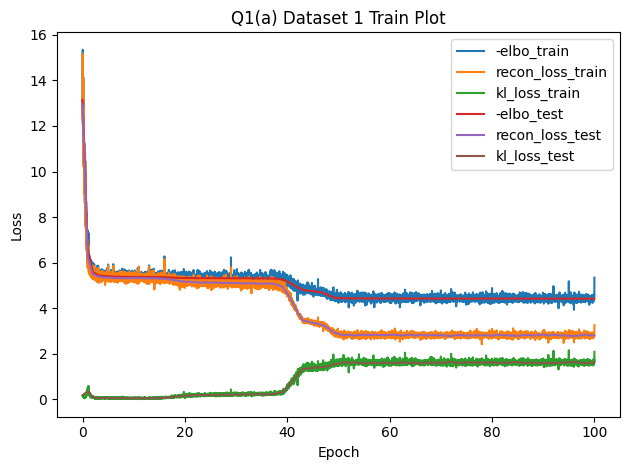

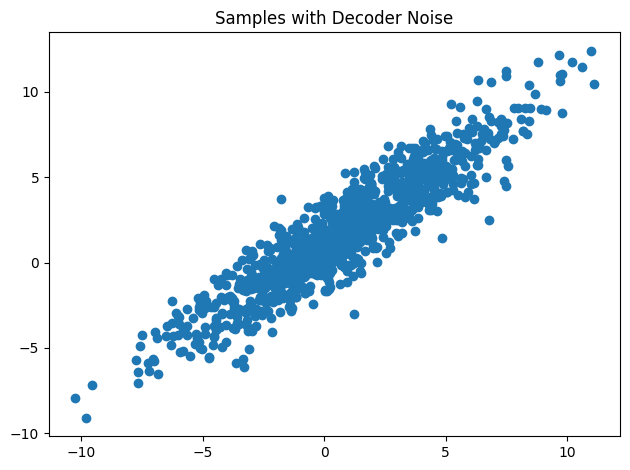

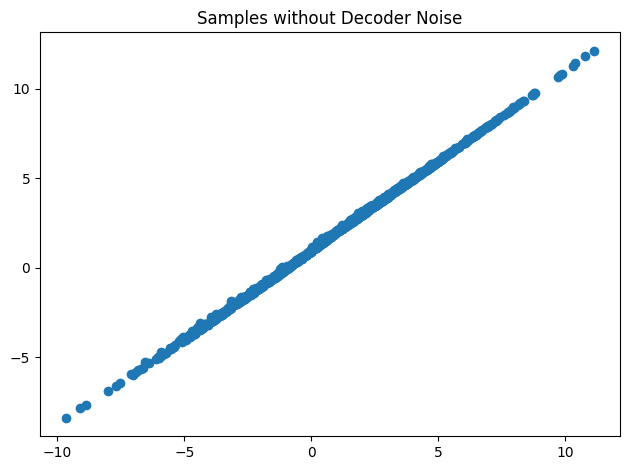

In [12]:
q1_save_results('a', 1, q1)

Epoch 0, ELBO 4.2357
Epoch 1, ELBO 3.0305
Epoch 2, ELBO 2.8042
Epoch 3, ELBO 2.7374
Epoch 4, ELBO 2.7125
Epoch 5, ELBO 2.6980
Epoch 6, ELBO 2.6929
Epoch 7, ELBO 2.6878
Epoch 8, ELBO 2.6815
Epoch 9, ELBO 2.6783
Epoch 10, ELBO 2.6715
Epoch 11, ELBO 2.6677
Epoch 12, ELBO 2.6647
Epoch 13, ELBO 2.6604
Epoch 14, ELBO 2.6557
Epoch 15, ELBO 2.6566
Epoch 16, ELBO 2.6536
Epoch 17, ELBO 2.6519
Epoch 18, ELBO 2.6507
Epoch 19, ELBO 2.6504
Epoch 20, ELBO 2.6477
Epoch 21, ELBO 2.6464
Epoch 22, ELBO 2.6473
Epoch 23, ELBO 2.6463
Epoch 24, ELBO 2.6441
Epoch 25, ELBO 2.6436
Epoch 26, ELBO 2.6420
Epoch 27, ELBO 2.6404
Epoch 28, ELBO 2.6399
Epoch 29, ELBO 2.6355
Epoch 30, ELBO 2.6293
Epoch 31, ELBO 2.6100
Epoch 32, ELBO 2.5435
Epoch 33, ELBO 2.4484
Epoch 34, ELBO 2.3445
Epoch 35, ELBO 2.2879
Epoch 36, ELBO 2.2592
Epoch 37, ELBO 2.2367
Epoch 38, ELBO 2.2291
Epoch 39, ELBO 2.2233
Epoch 40, ELBO 2.2189
Epoch 41, ELBO 2.2189
Epoch 42, ELBO 2.2163
Epoch 43, ELBO 2.2194
Epoch 44, ELBO 2.2141
Epoch 45, ELBO 2.214

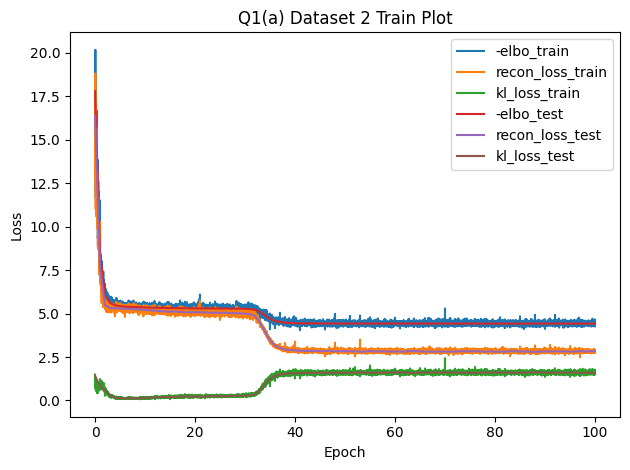

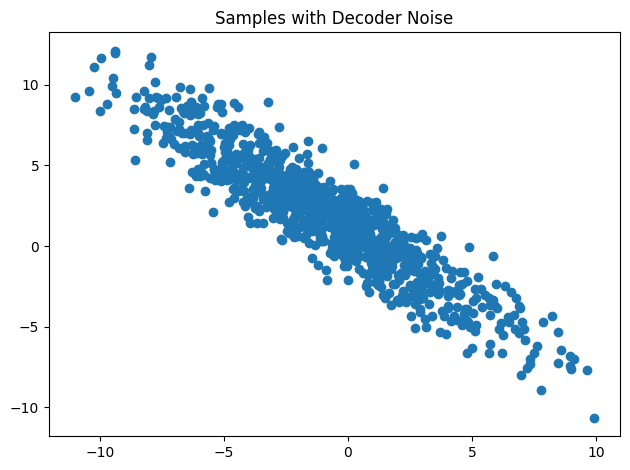

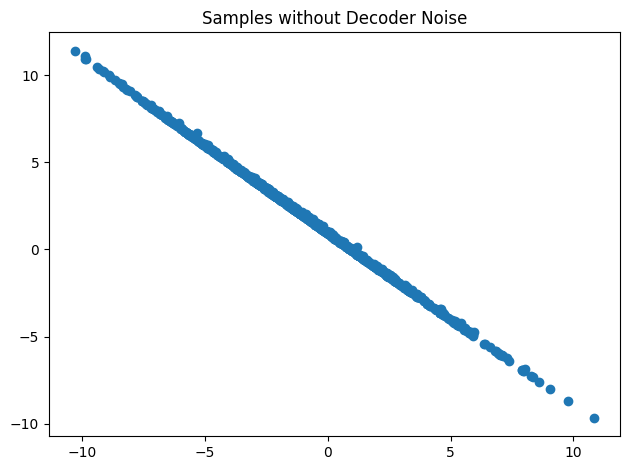

In [13]:
q1_save_results('a', 2, q1)

## Part (b) Data from a Diagonal Gaussian [10pts]
In this part, we use your code from the previous part to train a VAE on data generated from a diagonal gaussian. Execute the cell below to visualize the datasets (note that they may look the same, but notice the axes)

Dataset 1


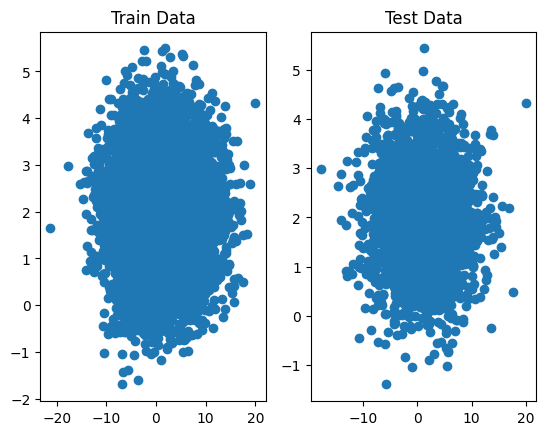

Dataset 2


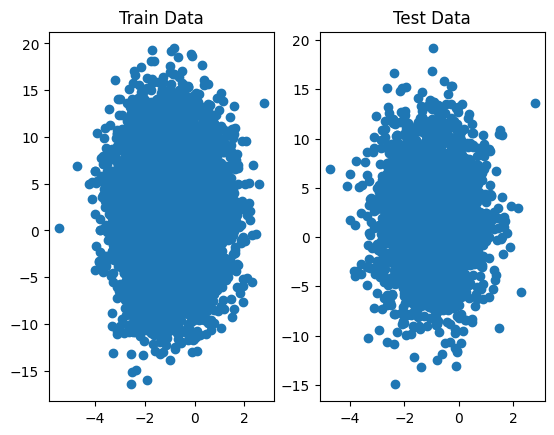

In [14]:
visualize_q1_data('b', 1)
visualize_q1_data('b', 2)

### Results
Execute the cells below to visualize and save your results.

Epoch 0, ELBO 4.4408
Epoch 1, ELBO 3.0676
Epoch 2, ELBO 2.7796
Epoch 3, ELBO 2.6499
Epoch 4, ELBO 2.5423
Epoch 5, ELBO 2.4402
Epoch 6, ELBO 2.3527
Epoch 7, ELBO 2.2853
Epoch 8, ELBO 2.2494
Epoch 9, ELBO 2.2349
Epoch 10, ELBO 2.2278
Epoch 11, ELBO 2.2224
Epoch 12, ELBO 2.2192
Epoch 13, ELBO 2.2174
Epoch 14, ELBO 2.2175
Epoch 15, ELBO 2.2151
Epoch 16, ELBO 2.2142
Epoch 17, ELBO 2.2138
Epoch 18, ELBO 2.2134
Epoch 19, ELBO 2.2125
Epoch 20, ELBO 2.2122
Epoch 21, ELBO 2.2126
Epoch 22, ELBO 2.2116
Epoch 23, ELBO 2.2116
Epoch 24, ELBO 2.2110
Epoch 25, ELBO 2.2114
Epoch 26, ELBO 2.2110
Epoch 27, ELBO 2.2114
Epoch 28, ELBO 2.2099
Epoch 29, ELBO 2.2104
Epoch 30, ELBO 2.2108
Epoch 31, ELBO 2.2103
Epoch 32, ELBO 2.2101
Epoch 33, ELBO 2.2106
Epoch 34, ELBO 2.2103
Epoch 35, ELBO 2.2108
Epoch 36, ELBO 2.2102
Epoch 37, ELBO 2.2102
Epoch 38, ELBO 2.2096
Epoch 39, ELBO 2.2098
Epoch 40, ELBO 2.2103
Epoch 41, ELBO 2.2098
Epoch 42, ELBO 2.2107
Epoch 43, ELBO 2.2100
Epoch 44, ELBO 2.2099
Epoch 45, ELBO 2.210

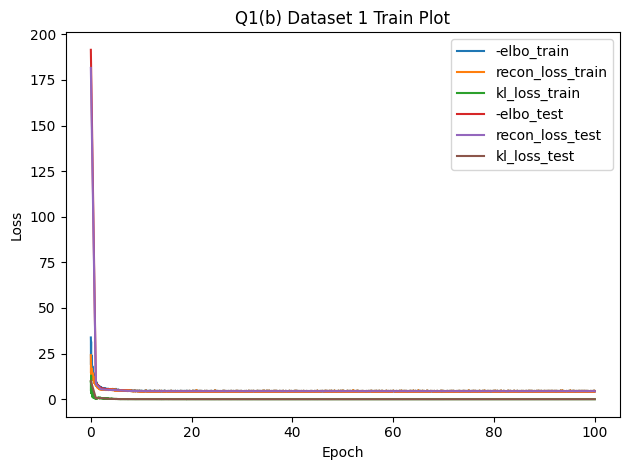

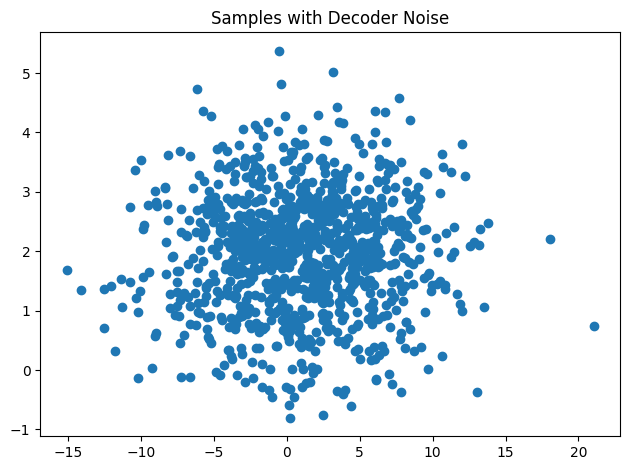

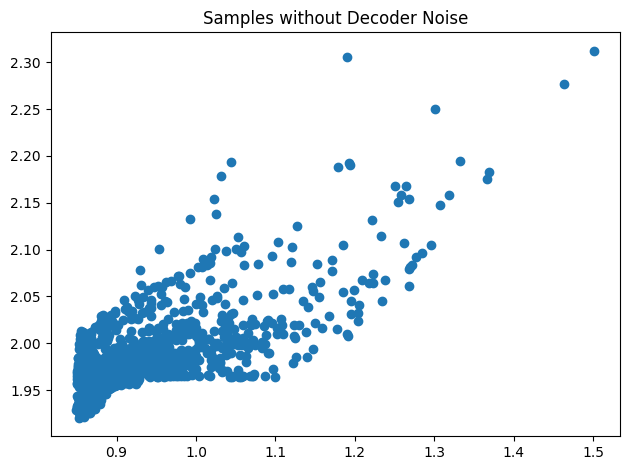

In [15]:
q1_save_results('b', 1, q1)

Epoch 0, ELBO 4.1128
Epoch 1, ELBO 2.8736
Epoch 2, ELBO 2.4523
Epoch 3, ELBO 2.3304
Epoch 4, ELBO 2.2800
Epoch 5, ELBO 2.2533
Epoch 6, ELBO 2.2436
Epoch 7, ELBO 2.2365
Epoch 8, ELBO 2.2313
Epoch 9, ELBO 2.2271
Epoch 10, ELBO 2.2230
Epoch 11, ELBO 2.2211
Epoch 12, ELBO 2.2186
Epoch 13, ELBO 2.2180
Epoch 14, ELBO 2.2164
Epoch 15, ELBO 2.2151
Epoch 16, ELBO 2.2141
Epoch 17, ELBO 2.2142
Epoch 18, ELBO 2.2127
Epoch 19, ELBO 2.2123
Epoch 20, ELBO 2.2121
Epoch 21, ELBO 2.2117
Epoch 22, ELBO 2.2116
Epoch 23, ELBO 2.2111
Epoch 24, ELBO 2.2115
Epoch 25, ELBO 2.2110
Epoch 26, ELBO 2.2112
Epoch 27, ELBO 2.2105
Epoch 28, ELBO 2.2110
Epoch 29, ELBO 2.2109
Epoch 30, ELBO 2.2102
Epoch 31, ELBO 2.2108
Epoch 32, ELBO 2.2109
Epoch 33, ELBO 2.2101
Epoch 34, ELBO 2.2106
Epoch 35, ELBO 2.2104
Epoch 36, ELBO 2.2103
Epoch 37, ELBO 2.2100
Epoch 38, ELBO 2.2098
Epoch 39, ELBO 2.2104
Epoch 40, ELBO 2.2103
Epoch 41, ELBO 2.2101
Epoch 42, ELBO 2.2097
Epoch 43, ELBO 2.2099
Epoch 44, ELBO 2.2095
Epoch 45, ELBO 2.210

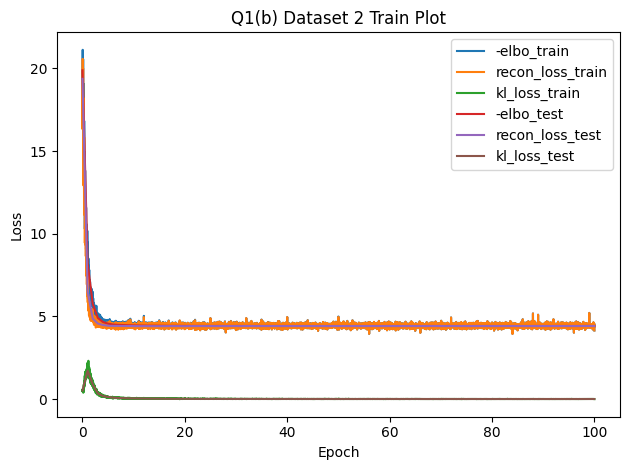

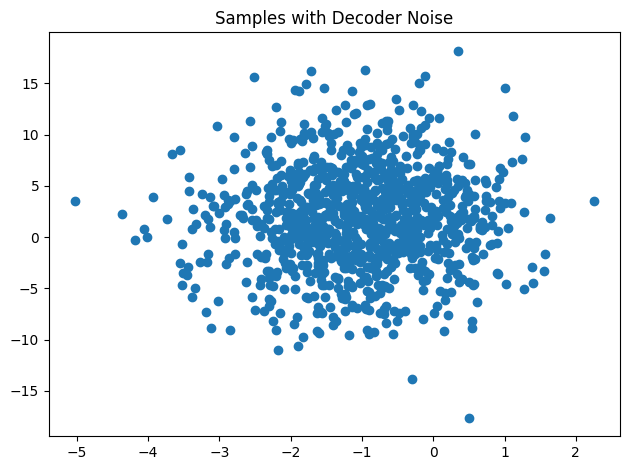

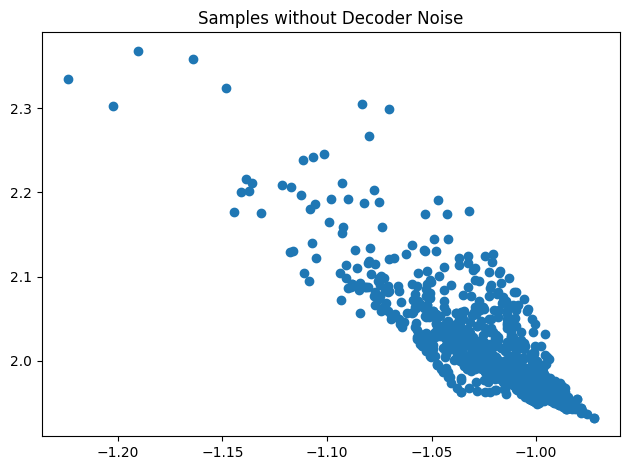

In [17]:
q1_save_results('b', 2, q1)

### Reflection
Compare the sampled xs with and without latents in parts (a) and (b). For which datasets are the latents being used? Why is this happening (i.e. why are the latents being ignored in some cases)? **Write your answer (1-2 sentences) in the given latex template**

# Question 2: VAEs on Images [40pts]
In this question, you will train different VAE models on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

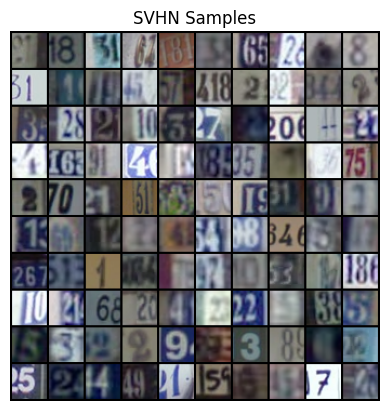

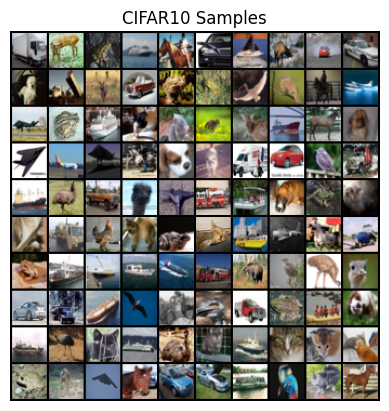

In [16]:
visualize_svhn()
visualize_cifar10()

## Part (a) VAE [20pts]
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu()
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten() # 16
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)



### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [7]:
class ImageVAE(nn.Module):
    def __init__(self, sample_num, latend_dim):
        super().__init__()
        self.sample_num = sample_num
        self.latent_dim = latend_dim
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.encoder_conv = nn.Sequential(nn.Conv2d(3, 32, 3, 1, 1),
                                          nn.ReLU(),
                                          nn.Conv2d(32, 64, 3, 2, 1),
                                          nn.ReLU(),
                                          nn.Conv2d(64, 128, 3, 2, 1),
                                          nn.ReLU(),
                                          nn.Conv2d(128, 256, 3, 2, 1),
                                          nn.ReLU())
        self.encoder_linear = nn.Linear(4 * 4 * 256, 2 * self.latent_dim)
        self.decoder_linear = nn.Sequential(nn.Linear(self.latent_dim, 4 * 4 * 128), nn.ReLU())

        self.decoder_conv = nn.Sequential(nn.ConvTranspose2d(128, 128, 4, 2, 1),
                                          nn.ReLU(),
                                          nn.ConvTranspose2d(128, 64, 4, 2, 1),
                                          nn.ReLU(),
                                          nn.ConvTranspose2d(64, 32, 4, 2, 1),
                                          nn.ReLU(),
                                          nn.Conv2d(32, 3, 3, 1, 1))

    def forward(self, x):
        # print(x.shape)
        batch_size = x.shape[0]
        x = x.permute(0, 3, 1, 2).to(self.device).float()
        outs = self.encoder_conv(x)
        # print(outs.shape)
        # outs = outs.view(size=(batch_size, -1))
        outs = outs.reshape(batch_size, -1)
        u_z, log_sigma_z = torch.chunk(self.encoder_linear(outs), 2, dim=-1)
        u_z = u_z.unsqueeze(1).repeat(1, self.sample_num, 1)
        sigma_z = torch.exp(log_sigma_z).unsqueeze(1).repeat(1, self.sample_num, 1)
        epsilon = torch.normal(0, 1, size=(batch_size, self.sample_num, self.latent_dim)).to(self.device)
        z_samples = u_z + epsilon * sigma_z

        z_samples = z_samples.view(size=(-1, self.latent_dim))
        z_outs = self.decoder_linear(z_samples)
        z_outs = z_outs.view(size=(batch_size * self.sample_num, 128, 4, 4))
        z_outs = self.decoder_conv(z_outs)
        z_outs = z_outs.view(batch_size, self.sample_num, 3, 32, 32)
        log_p_theta = Normal(z_outs, 1).log_prob(x.unsqueeze(1).repeat(1, self.sample_num, 1, 1, 1))
        log_p_z = Normal(0, 1).log_prob(z_samples).view(batch_size, self.sample_num, -1)
        log_q_phi = Normal(u_z, sigma_z).log_prob(z_samples.view(size=u_z.shape))
        mse_loss = (z_outs - x.unsqueeze(1).repeat(1, self.sample_num, 1, 1, 1)) ** 2

        return log_p_theta.sum(dim=[2, 3, 4]), log_p_z.sum(dim=[2]), log_q_phi.sum(dim=[2]), mse_loss.sum(
            dim=[2, 3, 4]), z_outs

    def loss(self, x):
        losses = self(x)
        elbo = torch.mean(losses[2] - losses[1] + losses[3])
        reconstruction_loss = torch.mean(losses[3])
        kl_loss = torch.mean(losses[2] - losses[1])
        return elbo, reconstruction_loss, kl_loss

    def sample(self):
        with torch.no_grad():
            z_samples = torch.normal(0, 1, size=(100, self.latent_dim)).to(self.device)
            z_outs = self.decoder_linear(z_samples)
            z_outs = z_outs.view(size=(100, 128, 4, 4))
            z_outs = self.decoder_conv(z_outs)
            return z_outs.permute(0, 2, 3, 1).cpu().data.numpy()

    def sample_pairs(self, x):
        pre_sample_num = self.sample_num
        self.sample_num = 1
        x = torch.from_numpy(x).to(self.device).float()
        with torch.no_grad():
            results = self(x)
            z_outs = torch.squeeze(results[-1])
            reconstructed_images = z_outs
        self.sample_num = pre_sample_num
        image_list = []
        for i in range(x.shape[0]):
            image_list.extend([x[i], reconstructed_images[i].permute(1, 2, 0)])
        return torch.stack(image_list, dim=0).cpu().data.numpy()

    def interpolation(self, x):
        batch_size = x.shape[0]
        x = torch.from_numpy(x)
        x = x.permute(0, 3, 1, 2).to(self.device).float()
        outs = self.encoder_conv(x)
        # outs = outs.view(size=(batch_size, -1))
        outs = outs.reshape(batch_size, -1)
        u_z, _ = torch.chunk(self.encoder_linear(outs), 2, dim=-1)

        image_list = []
        lamda = [(i + 1) / 9 for i in range(8)]
        for i in range(10):
            image_list.append(x[2 * i].permute(1, 2, 0))
            for coeff in lamda:
                z_samples = (1 - coeff) * u_z[2 * i] + coeff * u_z[2 * i + 1]
                z_outs = self.decoder_linear(z_samples)
                z_outs = z_outs.view(size=(1, 128, 4, 4))
                z_outs = self.decoder_conv(z_outs)
                z_outs = z_outs.view(1, 3, 32, 32)
                image_list.append(z_outs[0].permute(1, 2, 0))
            image_list.append(x[2 * i + 1].permute(1, 2, 0))
        return torch.stack(image_list, dim=0).cpu().data.numpy()

In [8]:
def q2_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    """ YOUR CODE HERE """
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    sample_num = 2
    latent_dim = 16
    model = ImageVAE(sample_num, latent_dim).to(device)
    best_model = ImageVAE(sample_num, latent_dim).to(device)
    train_data = (train_data / 255 - 0.5) * 2
    test_data = (test_data / 255 - 0.5) * 2
    images_set1 = train_data[0:50]
    images_set2 = train_data[0:20]
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=128)

    train_losses, test_losses = train_epochs(model, train_loader, test_loader, dict(epochs=50, lr=1e-3), best_model)
    best_model.eval()
    image_samples = (best_model.sample() + 1) * 255 / 2
    image_pairs = (best_model.sample_pairs(images_set1) + 1) * 255 / 2
    image_interpolation = (best_model.interpolation(images_set2) + 1) * 255 / 2
    return np.array(train_losses), np.array(test_losses), image_samples, image_pairs, image_interpolation

### Results
Once you've finished `q2_a`, execute the cells below to visualize and save your results.

Epoch 0, ELBO 322.7443
Epoch 1, ELBO 201.8775
Epoch 2, ELBO 160.3289
Epoch 3, ELBO 144.3339
Epoch 4, ELBO 134.8679
Epoch 5, ELBO 124.0249
Epoch 6, ELBO 114.7842
Epoch 7, ELBO 110.6729
Epoch 8, ELBO 109.7893
Epoch 9, ELBO 108.9467
Epoch 10, ELBO 108.5610
Epoch 11, ELBO 104.8194
Epoch 12, ELBO 105.1265
Epoch 13, ELBO 106.3371
Epoch 14, ELBO 104.3137
Epoch 15, ELBO 104.3075
Epoch 16, ELBO 104.1275
Epoch 17, ELBO 106.2879
Epoch 18, ELBO 103.1795
Epoch 19, ELBO 103.3418
Epoch 20, ELBO 110.8262
Epoch 21, ELBO 102.7453
Epoch 22, ELBO 102.4748
Epoch 23, ELBO 105.2404
Epoch 24, ELBO 104.1265
Epoch 25, ELBO 102.9218
Epoch 26, ELBO 104.5138
Epoch 27, ELBO 105.3947
Epoch 28, ELBO 103.4972
Epoch 29, ELBO 103.6760
Epoch 30, ELBO 103.0608
Epoch 31, ELBO 103.5648
Epoch 32, ELBO 107.6437
Epoch 33, ELBO 103.3065
Epoch 34, ELBO 105.8242
Epoch 35, ELBO 105.2920
Epoch 36, ELBO 104.8266
Epoch 37, ELBO 105.2489
Epoch 38, ELBO 106.4316
Epoch 39, ELBO 106.0855
Epoch 40, ELBO 105.0120
Epoch 41, ELBO 105.8255
Ep

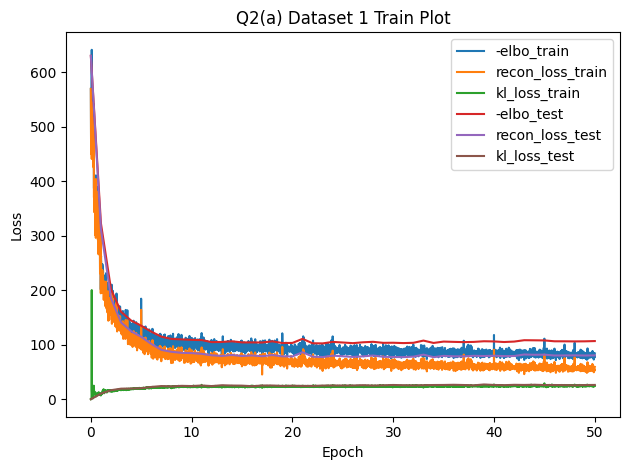

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


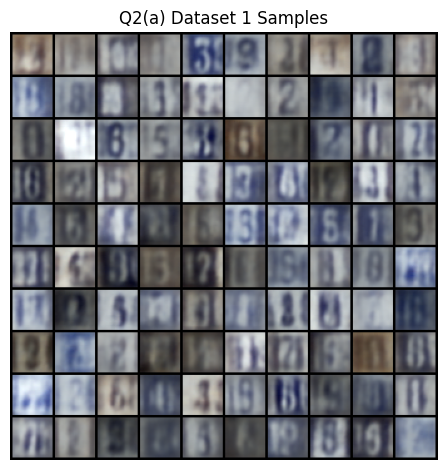

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


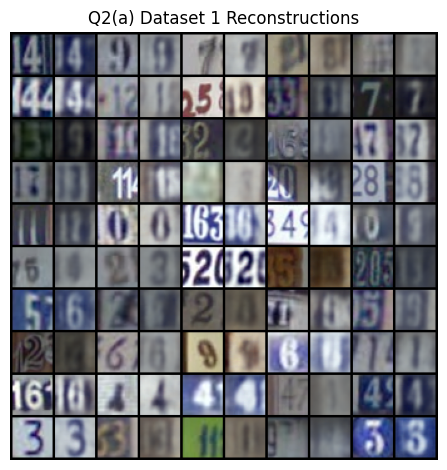

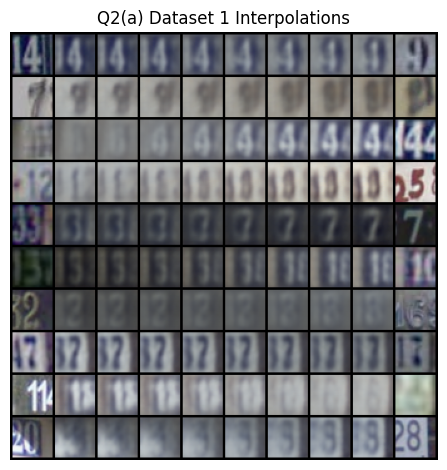

In [9]:
q2_save_results('a', 1, q2_a)

Epoch 0, ELBO 290.6982
Epoch 1, ELBO 249.1126
Epoch 2, ELBO 246.3957
Epoch 3, ELBO 244.6642
Epoch 4, ELBO 244.5019
Epoch 5, ELBO 242.1011
Epoch 6, ELBO 241.6398
Epoch 7, ELBO 240.1439
Epoch 8, ELBO 239.6990
Epoch 9, ELBO 239.9614
Epoch 10, ELBO 241.2237
Epoch 11, ELBO 239.3669
Epoch 12, ELBO 238.6368
Epoch 13, ELBO 240.6408
Epoch 14, ELBO 239.6075
Epoch 15, ELBO 238.1563
Epoch 16, ELBO 238.9587
Epoch 17, ELBO 239.1061
Epoch 18, ELBO 238.3180
Epoch 19, ELBO 238.5147
Epoch 20, ELBO 239.7865
Epoch 21, ELBO 238.3776
Epoch 22, ELBO 238.7092
Epoch 23, ELBO 238.4303
Epoch 24, ELBO 239.8907
Epoch 25, ELBO 239.3868
Epoch 26, ELBO 239.1025
Epoch 27, ELBO 239.0907
Epoch 28, ELBO 239.1134
Epoch 29, ELBO 239.8881
Epoch 30, ELBO 239.8266
Epoch 31, ELBO 239.9712
Epoch 32, ELBO 240.2791
Epoch 33, ELBO 241.0386
Epoch 34, ELBO 239.9992
Epoch 35, ELBO 240.5873
Epoch 36, ELBO 241.2186
Epoch 37, ELBO 242.4049
Epoch 38, ELBO 242.2714
Epoch 39, ELBO 241.3137
Epoch 40, ELBO 242.4048
Epoch 41, ELBO 241.4977
Ep

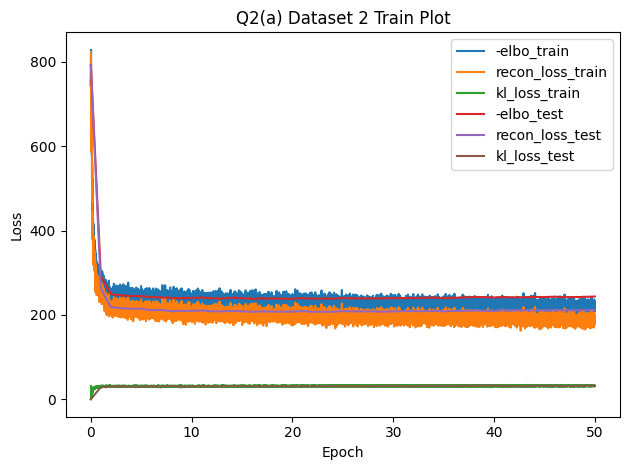

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


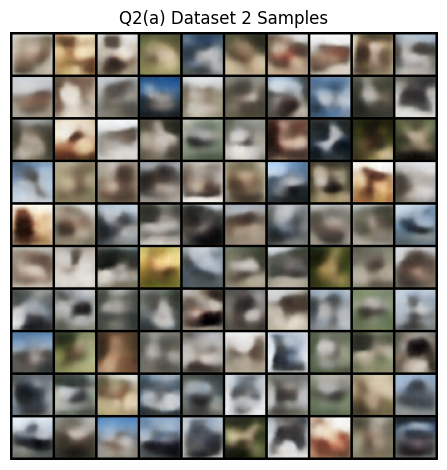

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


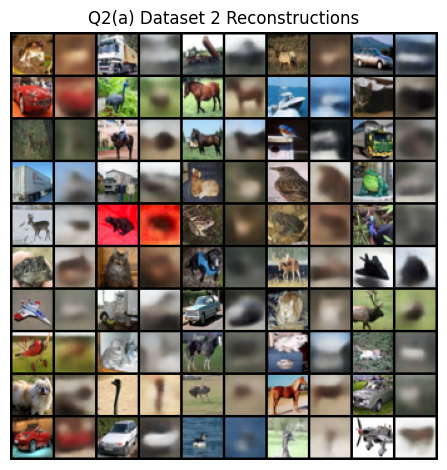

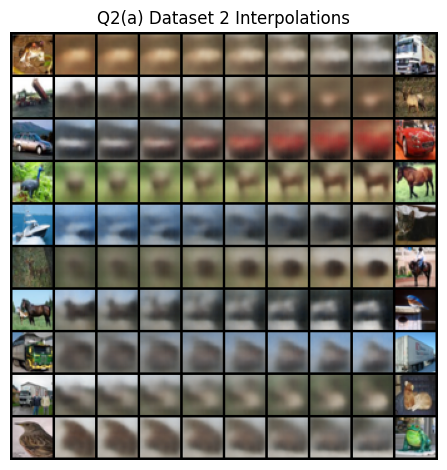

In [10]:
q2_save_results('a', 2, q2_a)

## Part (b) Hierarchical VAE [20pts]

In this part, we will explore a simplified version of the hierarchical VAE described in [NVAE](https://arxiv.org/pdf/2007.03898.pdf). We will not implement the full NVAE, but rather use some ideas from the paper to explore how to learn a prior distribution p(z).

Implement a hierarchical VAE that follows the following structure.
* $z1$ is an 8x8x12 latent vector where p(z1) is the unit Gaussian.
    * Learn the approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix. I.e., same as a normal VAE, but use a matrix latent rather than a vector. Each dimension is independent.
* $z2$ is an 8x8x12 latent vector.
    * $p_\theta(z2|z1)$ is learned, and implemented as a neural network that parameterizes mean (and log std, optionally).
    * $q_\theta(z2|z1,x)$ is also learned. Implement this as a Residual Normal [see NVAE] over the prior $p_\theta(z2|z1)$.
* The decoder should be a function of $z2$ only.

Some helpful hints:
* Two KL losses should be calculated. The first should match $q_\theta(z|x)$ to the unit Gaussian. The second should match $q_\theta(z2|z1,x)$ and $p_\theta(z2|z1)$, and be taken with respect to $q$.
* When calculating the second KL term, utilize the analytic form for the residual normal. When $q_\theta(z2|z1,x) = N(z2; \mu_\theta(z1) + \Delta \mu_\theta(z1,x), \Sigma_\theta(z1)) * \Delta \Sigma_\theta(z1,x))$, use the following form: `kl_z2 = -z2_residual_logstd - 0.5 + (torch.exp(2 * z2_residual_logstd) + z2_residual_mu ** 2) * 0.5`
* When calculating KL, remember to sum over the dimensions of the latent variable before taking the mean over batch.
* For the prior $p_\theta(z2|z1)$, fix standard deviation to be 1. Learn only the mean. This will help with stability in training.

The following network structures may be useful:
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
        nn.Conv2d(3 + 12, 32, 3, padding=1), # [32, 32, 32]
        LayerNorm(32),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, stride=2, padding=1), # [64, 16, 16]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 8, 8]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 4, 2]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 2, 4]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 12*2, 3, padding=1), # [12*2, 2, 2]
We assume encoder networks are of the form p(z'|z,x).
When learning q(z1), an x of all zeros can be used as input.
Upscale z with nearest-neighbor projection before concatenating with x.


Decoder
        nn.ConvTranspose2d(12, 64, 3, padding=1), # [64, 2, 2]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 4, 4]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 8, 8]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 16, 16]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), # [32, 32, 32]
        nn.ReLU(),
        nn.Conv2d(32, 3, 3, padding=1), # [3, 32, 32]
```


**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [17]:
import torch.nn.functional as F

class MaskedLinear(torch.nn.Linear):
    """ same as Linear except has a configurable mask on the weights """

    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer('mask', torch.ones(out_features, in_features))

    def set_mask(self, mask):
        self.mask.data.copy_(mask)

    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)


class Made(torch.nn.Module):
    def __init__(self, masked_matrix_list, hidden_units):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.register_parameter("shift", nn.Parameter(torch.ones(size=(1, hidden_units[-1] // 2)), requires_grad=True))
        self.register_parameter("scale", nn.Parameter(torch.ones(size=(1, hidden_units[-1] // 2)), requires_grad=True))
        self.fc1 = MaskedLinear(hidden_units[0], hidden_units[1])
        self.fc1.set_mask(masked_matrix_list[0])
        self.fc2 = MaskedLinear(hidden_units[1], hidden_units[2])
        self.fc2.set_mask(masked_matrix_list[1])
        self.fc3 = MaskedLinear(hidden_units[2], hidden_units[3])
        self.fc3.set_mask(masked_matrix_list[2])
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.masked_matrix_list = masked_matrix_list
        self.latent_dim = hidden_units[-1] // 2

    def forward(self, inputs):
        inputs = inputs.to(self.device)
        outs = self.relu(self.fc1(inputs))
        outs = self.relu(self.fc2(outs))
        log_s, t = torch.chunk(self.relu(self.fc3(outs)), chunks=2, dim=-1)
        log_s = self.scale * self.tanh(log_s) + self.shift
        epsilon = inputs * torch.exp(log_s) + t
        log_p_epsilon = Normal(0, 1).log_prob(epsilon)
        log_det = log_s
        return log_p_epsilon + log_det

    def sample(self, sample_num):
        z = torch.normal(0, 1, size=(sample_num, self.latent_dim))
        x = torch.zeros(size=z.shape)
        for _ in range(self.latent_dim):
            x = self.inverse(z, x)
        return x

    def inverse(self, z, x):
        z = z.to(self.device)
        x = x.to(self.device)
        outs = self.relu(self.fc1(x))
        outs = self.relu(self.fc2(outs))
        log_s, t = torch.chunk(self.relu(self.fc3(outs)), chunks=2, dim=-1)
        log_s = self.scale * self.tanh(log_s) + self.shift
        x = (z - t) / torch.exp(log_s)
        return x
class ImageVAEAFPrior(nn.Module):
    def __init__(self, sample_num, latent_dim):
        super().__init__()
        self.sample_num = sample_num
        self.latent_dim = latent_dim
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.encoder_conv = nn.Sequential(nn.Conv2d(3, 32, 3, 1, 1),
                                          nn.ReLU(),
                                          nn.Conv2d(32, 64, 3, 2, 1),
                                          nn.ReLU(),
                                          nn.Conv2d(64, 128, 3, 2, 1),
                                          nn.ReLU(),
                                          nn.Conv2d(128, 256, 3, 2, 1),
                                          nn.ReLU())
        self.encoder_linear = nn.Linear(4 * 4 * 256, 2 * self.latent_dim)
        self.decoder_linear = nn.Sequential(nn.Linear(self.latent_dim, 4 * 4 * 128), nn.ReLU())
        self.decoder_conv = nn.Sequential(nn.ConvTranspose2d(128, 128, 4, 2, 1),
                                          nn.ReLU(),
                                          nn.ConvTranspose2d(128, 64, 4, 2, 1),
                                          nn.ReLU(),
                                          nn.ConvTranspose2d(64, 32, 4, 2, 1),
                                          nn.ReLU(),
                                          nn.Conv2d(32, 3, 3, 1, 1), nn.Tanh())
        hidden_units = [latent_dim, 256, 256, 2 * latent_dim]
        m0 = np.array([i + 1 for i in range(latent_dim)], dtype=np.int8)
        m1 = np.random.randint(low=1, high=latent_dim, size=hidden_units[1])
        m2 = np.random.randint(low=1, high=latent_dim, size=hidden_units[2])
        m3 = np.array([i + 1 for i in range(latent_dim)] * 2, dtype=np.int8)
        M1 = torch.from_numpy(m1[np.newaxis].transpose() >= m0[np.newaxis])
        M2 = torch.from_numpy(m2[np.newaxis].transpose() >= m1[np.newaxis])
        M3 = torch.from_numpy(m3[np.newaxis].transpose() > m2[np.newaxis])
        self.af_flow = Made([M1, M2, M3], hidden_units)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.permute(0, 3, 1, 2).to(self.device).float()
        outs = self.encoder_conv(x)
        # outs = outs.view(size=(batch_size, -1))
        outs = outs.reshape(batch_size, -1)
        u_z, log_sigma_z = torch.chunk(self.encoder_linear(outs), 2, dim=-1)
        u_z = u_z.unsqueeze(1).repeat(1, self.sample_num, 1)
        sigma_z = torch.exp(log_sigma_z).unsqueeze(1).repeat(1, self.sample_num, 1)
        epsilon = torch.normal(0, 1, size=(batch_size, self.sample_num, self.latent_dim)).to(self.device)
        z_samples = u_z + epsilon * sigma_z

        z_samples = z_samples.view(size=(-1, self.latent_dim))
        z_outs = self.decoder_linear(z_samples)
        z_outs = z_outs.view(size=(batch_size * self.sample_num, 128, 4, 4))
        z_outs = self.decoder_conv(z_outs)
        z_outs = z_outs.view(batch_size, self.sample_num, 3, 32, 32)
        log_p_theta = Normal(z_outs, 1).log_prob(x.unsqueeze(1).repeat(1, self.sample_num, 1, 1, 1))
        log_p_z = self.af_flow.forward(z_samples).view(batch_size, self.sample_num, -1)
        log_q_phi = Normal(u_z, sigma_z).log_prob(z_samples.view(size=u_z.shape))
        mse_loss = (z_outs - x.unsqueeze(1).repeat(1, self.sample_num, 1, 1, 1)) ** 2

        return log_p_theta.sum(dim=[2, 3, 4]), log_p_z.sum(dim=[2]), log_q_phi.sum(dim=[2]), mse_loss.sum(
            dim=[2, 3, 4]), z_outs

    def loss(self, x):
        losses = self(x)
        elbo = torch.mean(losses[2] - losses[1] + losses[3])
        reconstruction_loss = torch.mean(losses[3])
        kl_loss = torch.mean(losses[2] - losses[1])
        return elbo, reconstruction_loss, kl_loss

    def sample(self):
        with torch.no_grad():
            z_samples = self.af_flow.sample(100).to(self.device)
            z_outs = self.decoder_linear(z_samples)
            z_outs = z_outs.view(size=(100, 128, 4, 4))
            z_outs = self.decoder_conv(z_outs)
            return z_outs.permute(0, 2, 3, 1).cpu().data.numpy()

    def sample_pairs(self, x):
        pre_sample_num = self.sample_num
        self.sample_num = 1
        x = torch.from_numpy(x).to(self.device).float()
        with torch.no_grad():
            results = self(x)
            z_outs = torch.squeeze(results[-1])
            reconstructed_images = z_outs
        self.sample_num = pre_sample_num
        image_list = []
        for i in range(x.shape[0]):
            image_list.extend([x[i], reconstructed_images[i].permute(1, 2, 0)])
        return torch.stack(image_list, dim=0).cpu().data.numpy()

    def interpolation(self, x):
        batch_size = x.shape[0]
        x = torch.from_numpy(x)
        x = x.permute(0, 3, 1, 2).to(self.device).float()
        outs = self.encoder_conv(x)
        # outs = outs.view(size=(batch_size, -1))
        outs = outs.reshape(batch_size, -1)
        u_z, _ = torch.chunk(self.encoder_linear(outs), 2, dim=-1)

        image_list = []
        lamda = [(i + 1) / 9 for i in range(8)]
        for i in range(10):
            image_list.append(x[2 * i].permute(1, 2, 0))
            for coeff in lamda:
                z_samples = (1 - coeff) * u_z[2 * i] + coeff * u_z[2 * i + 1]
                z_outs = self.decoder_linear(z_samples)
                z_outs = z_outs.view(size=(1, 128, 4, 4))
                z_outs = self.decoder_conv(z_outs)
                z_outs = z_outs.view(1, 3, 32, 32)
                image_list.append(z_outs[0].permute(1, 2, 0))
            image_list.append(x[2 * i + 1].permute(1, 2, 0))
        return torch.stack(image_list, dim=0).cpu().data.numpy()

In [18]:
def q2_b(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    """ YOUR CODE HERE """
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    sample_num = 2
    latent_dim = 16
    model = ImageVAEAFPrior(sample_num, latent_dim).to(device)
    best_model = ImageVAEAFPrior(sample_num, latent_dim).to(device)
    train_data = (train_data / 255 - 0.5) * 2
    test_data = (test_data / 255 - 0.5) * 2
    images_set1 = train_data[0:50]
    images_set2 = train_data[0:20]
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=128)

    train_losses, test_losses = train_epochs(model, train_loader, test_loader, dict(epochs=50, lr=1e-3), best_model)
    best_model.eval()
    image_samples = (best_model.sample() + 1) * 255 / 2
    image_pairs = (best_model.sample_pairs(images_set1) + 1) * 255 / 2
    image_interpolation = (best_model.interpolation(images_set2) + 1) * 255 / 2
    return np.array(train_losses), np.array(test_losses), image_samples, image_pairs, image_interpolation

### Results
Once you've finished `q2_b`, execute the cells below to visualize and save your results.

Epoch 0, ELBO 344.3966
Epoch 1, ELBO 199.7503
Epoch 2, ELBO 166.7944
Epoch 3, ELBO 151.8327
Epoch 4, ELBO 138.4361
Epoch 5, ELBO 137.5346
Epoch 6, ELBO 120.8732
Epoch 7, ELBO 116.3043
Epoch 8, ELBO 110.4991
Epoch 9, ELBO 108.5969
Epoch 10, ELBO 107.9326
Epoch 11, ELBO 106.3969
Epoch 12, ELBO 105.5933
Epoch 13, ELBO 106.4774
Epoch 14, ELBO 104.6891
Epoch 15, ELBO 110.0757
Epoch 16, ELBO 104.2202
Epoch 17, ELBO 104.3359
Epoch 18, ELBO 104.7174
Epoch 19, ELBO 103.1655
Epoch 20, ELBO 104.5775
Epoch 21, ELBO 104.3335
Epoch 22, ELBO 103.5333
Epoch 23, ELBO 103.1810
Epoch 24, ELBO 102.8181
Epoch 25, ELBO 102.7933
Epoch 26, ELBO 103.2544
Epoch 27, ELBO 106.1997
Epoch 28, ELBO 103.0737
Epoch 29, ELBO 108.7327
Epoch 30, ELBO 103.6177
Epoch 31, ELBO 102.7537
Epoch 32, ELBO 104.7190
Epoch 33, ELBO 103.4965
Epoch 34, ELBO 102.2786
Epoch 35, ELBO 102.3446
Epoch 36, ELBO 102.7618
Epoch 37, ELBO 103.5035
Epoch 38, ELBO 103.3693
Epoch 39, ELBO 105.0250
Epoch 40, ELBO 103.8766
Epoch 41, ELBO 104.4930
Ep

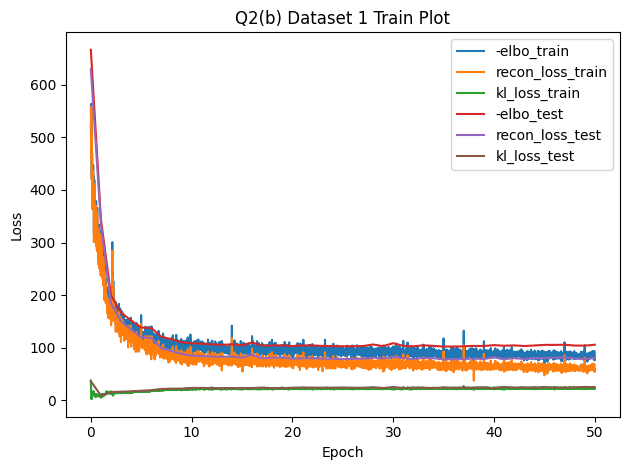

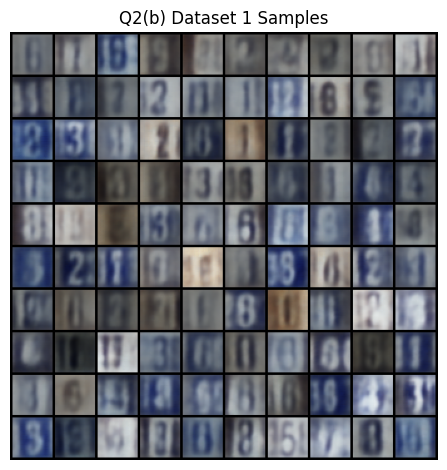

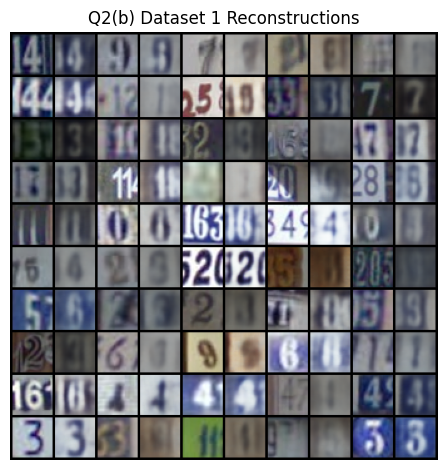

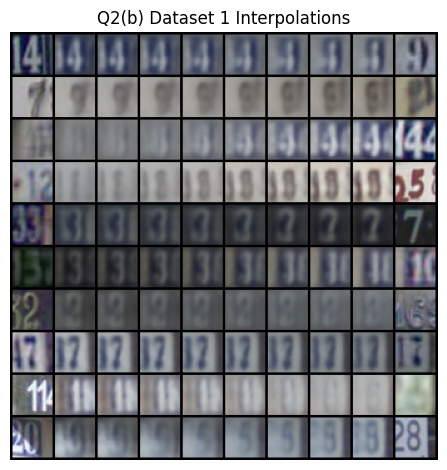

In [19]:
q2_save_results('b', 1, q2_b)

In [ ]:
q2_save_results('b', 2, q2_b)

# Question 3: VQ-VAE [40pts]
In this question, you with train a [VQ-VAE](https://arxiv.org/abs/1711.00937) on the colored shapes dataset and SVHN. If you are confused on how the VQ-VAE works, you may find [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) to be useful.

You may experiment with different hyperparameters and architecture designs, but the following designs for the VQ-VAE architecture may be useful.

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)

residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
```

A few other tips:
*   Use a codebook with $K = 128$ latents each with a $D = 256$ dimensional embedding vector
*   You should initialize each element in your $K\times D$ codebook to be uniformly random in $[-1/K, 1/K]$
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer
*   Center and scale your images to $[-1, 1]$
*   Supposing that $z_e(x)$ is the encoder output, and $z_q(x)$ is the quantized output using the codebook, you can implement the straight-through estimator as follows (where below is fed into the decoder):
  * `(z_q(x) - z_e(x)).detach() + z_e(x)` in Pytorch
  * `tf.stop_gradient(z_q(x) - z_e(x)) + z_e(x)` in Tensorflow.

In addition to training the VQ-VAE, you will also need to train a Transformer prior on the categorical latents in order to sample. Feel free to use your implementation for HW1! You should flatten the VQ-VAE tokens into a [H x W] sequence, and use a start token.

**You will provide the following deliverables**


1.   Over the course of training, record the average loss of the training data (per minibatch) and test data (for your entire test set) **for both your VQ-VAE and Transformer prior**. Code is provided that automatically plots the training curves.
2. Report the final test set performances of your final models
3. 100 samples from your trained VQ-VAE and Transformer prior
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)

## Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [20]:
def vq_train(model, train_loader, optimizer, grad_clip=None):
    model.train()
    train_losses = []
    for x in train_loader:
        loss = model.loss(x)
        optimizer.zero_grad()
        loss.backward()
        if grad_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        train_losses.append(loss.cpu().item())
    return train_losses


def vq_eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    for x in data_loader:
        with torch.no_grad():
            loss = model.loss(x)
            total_loss += loss.cpu().item() * x.shape[0]
    avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss


def vq_train_epochs(model, train_loader, test_loader, train_args, best_model=None):
    epochs, lr = train_args['epochs'], train_args['lr']
    grad_clip = train_args.get('grad_clip', None)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_loss = 1e8
    test_losses = [vq_eval_loss(model, test_loader)]
    print(f"initial test loss is {test_losses[0]}")
    train_losses = []
    # test_losses = [0,]
    # train_losses = [0,]
    for epoch in range(epochs):
        train_losses.extend(vq_train(model, train_loader, optimizer, grad_clip))
        test_losses.append(vq_eval_loss(model, test_loader))
        if test_losses[-1] < best_loss:
            best_loss = test_losses[-1]
            best_model.load_state_dict(model.state_dict())
        print(f'Epoch {epoch}, loss {test_losses[-1]:.4f}')
    print(f"best loss is {best_loss}")
    return train_losses, test_losses


class LayerNorm(nn.LayerNorm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x = super().forward(x)
        return x.permute(0, 3, 1, 2).contiguous()


class MaskedConv2d(torch.nn.Conv2d):
    def __init__(self, mask_type, c_in, c_out, k_size, stride, pad):
        """2D Convolution with masked weight for Autoregressive connection"""
        super(MaskedConv2d, self).__init__(
            c_in, c_out, k_size, stride, pad, bias=False)
        assert mask_type in ['A', 'B']
        self.mask_type = mask_type
        ch_out, ch_in, height, width = self.weight.size()

        mask = torch.ones(ch_out, ch_in, height, width)
        mask[:, :, height // 2, width // 2:] = 0
        mask[:, :, height // 2 + 1:, :] = 0
        mask[:, :, height // 2, width // 2] = 1 if self.mask_type == 'B' else 0
        self.register_buffer('mask', mask)

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)


class MaskedConv2dBlock(nn.Module):
    def __init__(self, mask_type, c_in, c_out, k_size, stride, pad):
        super().__init__()
        self.mask_conv = nn.Sequential(*[MaskedConv2d(mask_type, c_in, c_out, k_size, stride, pad)] * 2)

    def forward(self, x):
        return self.mask_conv(x) + x


class ResidualBlocks(nn.Module):
    def __init__(self, kernel_num):
        super().__init__()
        self.kernel_num = kernel_num
        self.net = nn.Sequential(
            nn.BatchNorm2d(kernel_num),
            nn.ReLU(),
            nn.Conv2d(kernel_num, kernel_num, 3, 1, 1),
            nn.BatchNorm2d(kernel_num),
            nn.ReLU(),
            nn.Conv2d(kernel_num, kernel_num, 3, 1, 1))
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, x):
        x = x.to(self.device)
        return self.net(x) + x


class PixelCNN(torch.nn.Module):
    def __init__(self, channel_in, channel_out, vq_vae):
        super().__init__()
        self.vae = vq_vae
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.embedding = nn.Embedding(channel_out, 64)
        self.maskA_block = torch.nn.Sequential(
            MaskedConv2d('A', 64, 64, 7, 1, 3),
            LayerNorm(64),
            torch.nn.ReLU()
        )

        self.maskB_block = torch.nn.Sequential(*[MaskedConv2d('B', 64, 64, 7, 1, 3),
                                                 LayerNorm(64),
                                                 torch.nn.ReLU()] * 4)

        self.one_one_conv = torch.nn.Sequential(
            MaskedConv2d('B', 64, 128, 1, 1, 0),
            LayerNorm(128),
            torch.nn.ReLU(),
            MaskedConv2d('B', 128, channel_out, 1, 1, 0),
        )
        self.criteria = nn.CrossEntropyLoss()
        self.latent_num = channel_out

    def forward(self, x):
        x = x.to(self.device).float()
        self.vae.eval()
        with torch.no_grad():
            zq_index = self.vae(x)[-2]
        outs = self.embedding(zq_index).permute(0, 3, 1, 2)
        outs = self.maskA_block(outs)
        outs = self.maskB_block(outs)
        outs = self.one_one_conv(outs)
        return self.criteria(outs, zq_index)

    def loss(self, x):
        return self(x)

    def sample(self):
        self.vae.eval()
        self.eval()
        with torch.no_grad():
            zq_index = torch.zeros((100, 8, 8)).to(self.device)
            for j in range(8):
                for k in range(8):
                    outs = self.embedding(zq_index.long()).permute(0, 3, 1, 2)
                    outs = self.maskA_block(outs)
                    outs = self.maskB_block(outs)
                    outs = self.one_one_conv(outs)
                    outs = torch.softmax(outs, dim=1)
                    cate_distr = torch.distributions.Categorical(outs.permute(0, 2, 3, 1).reshape(-1, self.latent_num))
                    zq_index.data[:, j, k] = cate_distr.sample().reshape(outs.shape[0], 8, 8)[:, j, k]

            return self.vae.sample(zq_index).permute(0, 2, 3, 1).cpu().numpy()

    def to_one_hot(self, zq_index_):
        zq_index = torch.flatten(zq_index_)
        zq_index = torch.zeros(size=(zq_index.shape[0], self.latent_num)).to(self.device)
        zq_index.zero_()
        zq_index.scatter_(1, torch.flatten(zq_index_).unsqueeze(1), 1)
        zq_index = zq_index.reshape(shape=list(zq_index_.shape) + [-1, ]).float()
        return zq_index.permute(0, 3, 1, 2).contiguous()


class VQVAE(nn.Module):
    def __init__(self, latents_dim, latents_num):
        super().__init__()
        self.latents_dim = latents_dim
        self.latents_num = latents_num
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.encoder = nn.Sequential(nn.Conv2d(3, latents_dim, 4, 2, 1),
                                     nn.BatchNorm2d(latents_dim),
                                     nn.ReLU(),
                                     nn.Conv2d(latents_dim, latents_dim, 4, 2, 1),
                                     ResidualBlocks(latents_dim),
                                     ResidualBlocks(latents_dim)
                                     )
        self.decoder = nn.Sequential(ResidualBlocks(latents_dim),
                                     ResidualBlocks(latents_dim),
                                     nn.BatchNorm2d(latents_dim),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(latents_dim, latents_dim, 4, 2, 1),
                                     nn.BatchNorm2d(latents_dim),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(latents_dim, 3, 4, 2, 1))
        code_book = 2 * (torch.rand(size=(latents_num, latents_dim), requires_grad=True) - 0.5) / latents_num
        self.register_parameter("code_book", nn.Parameter(code_book, requires_grad=True))

    def forward(self, x):
        x = x.to(self.device).permute(0, 3, 1, 2).float()
        batch_size = x.shape[0]
        ze = self.encoder(x)
        ze_repeated = ze.unsqueeze(-1).repeat(1, 1, 1, 1, self.latents_num).permute(0, 2, 3, 4, 1)
        code_book_repeated = self.code_book.unsqueeze(0).unsqueeze(0).unsqueeze(0).repeat(batch_size, 8, 8, 1, 1)
        distance = torch.sum((ze_repeated - code_book_repeated) ** 2, dim=-1)
        q_index = torch.argmin(distance, dim=-1)
        zq_with_grad = self.code_book[q_index].permute(0, 3, 1, 2)
        zq = ze + (zq_with_grad - ze).detach()
        outs = self.decoder(zq)
        recon_loss = (x - outs) ** 2
        vq_loss = (ze.detach() - zq_with_grad) ** 2
        commit_loss = (ze - zq_with_grad.detach()) ** 2
        return torch.mean(recon_loss), torch.mean(vq_loss), torch.mean(commit_loss), q_index.long(), outs

    def loss(self, x):
        losses = self(x)
        return torch.mean(losses[0] + losses[1] + losses[2])

    def sample(self, zq_index):
        zq = self.code_book[zq_index.long()].permute(0, 3, 1, 2)
        with torch.no_grad():
            return self.decoder(zq)

    def sample_pairs(self, x):
        x = torch.from_numpy(x).to(self.device)
        with torch.no_grad():
            results = self(x)
            reconstructed_images = results[-1]
        image_list = []
        for i in range(x.shape[0]):
            image_list.extend([x[i].float(), reconstructed_images[i].permute(1, 2, 0)])
        return torch.stack(image_list, dim=0).cpu().numpy()

In [21]:
def q3(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE train losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of PixelCNN prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of PixelCNN prior train losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples (an equal number from each class) with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """

    """ YOUR CODE HERE """
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    latents_dim = 256
    latents_num = 128
    model = VQVAE(latents_dim, latents_num).to(device)
    best_model = VQVAE(latents_dim, latents_num).to(device)
    pixel_cnn = PixelCNN(64, latents_num, best_model).to(device)
    best_pixel_cnn = PixelCNN(64, latents_num, best_model).to(device)

    train_data = (train_data / 255 - 0.5) * 2
    test_data = (test_data / 255 - 0.5) * 2
    images_set1 = train_data[0:50]
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=128)

    train_losses, test_losses = vq_train_epochs(model, train_loader, test_loader, dict(epochs=35, lr=1e-3), best_model)
    best_model.eval()
    image_pairs = np.clip((best_model.sample_pairs(images_set1) + 1) * 255 / 2, 0, 255)

    train_pixel_cnn, test_pixel_cnn = vq_train_epochs(pixel_cnn, train_loader, test_loader, dict(epochs=25, lr=1e-3),
                                                      best_pixel_cnn)
    best_pixel_cnn.eval()
    images_samples = np.clip((best_pixel_cnn.sample() + 1) * 255 / 2, 0, 255)

    return np.array(train_losses), np.array(test_losses), np.array(train_pixel_cnn), np.array(test_pixel_cnn), np.floor(
        images_samples), np.floor(image_pairs)

## Results
Once you've finished `q3`, execute the cells below to visualize and save your results.

initial test loss is 0.22232023898363112
Epoch 0, loss 3.6396
Epoch 1, loss 0.7730
Epoch 2, loss 0.3774
Epoch 3, loss 0.2524
Epoch 4, loss 0.1679
Epoch 5, loss 0.1338
Epoch 6, loss 0.1114
Epoch 7, loss 0.0915
Epoch 8, loss 0.0801
Epoch 9, loss 0.0708
Epoch 10, loss 0.0586
Epoch 11, loss 0.0592
Epoch 12, loss 0.0499
Epoch 13, loss 0.0483
Epoch 14, loss 0.0454
Epoch 15, loss 0.0437
Epoch 16, loss 0.0409
Epoch 17, loss 0.0368
Epoch 18, loss 0.0372
Epoch 19, loss 0.0376
Epoch 20, loss 0.0373
Epoch 21, loss 0.0346
Epoch 22, loss 0.0332
Epoch 23, loss 0.0355
Epoch 24, loss 0.0320
Epoch 25, loss 0.0373
Epoch 26, loss 0.0301
Epoch 27, loss 0.0316
Epoch 28, loss 0.0286
Epoch 29, loss 0.0295
Epoch 30, loss 0.0340
Epoch 31, loss 0.0296
Epoch 32, loss 0.0410
Epoch 33, loss 0.0276
Epoch 34, loss 0.0347
best loss is 0.027575342613458634
initial test loss is 4.909401221466064
Epoch 0, loss 3.7351
Epoch 1, loss 3.7226
Epoch 2, loss 3.1319
Epoch 3, loss 2.6315
Epoch 4, loss 2.3518
Epoch 5, loss 2.2697


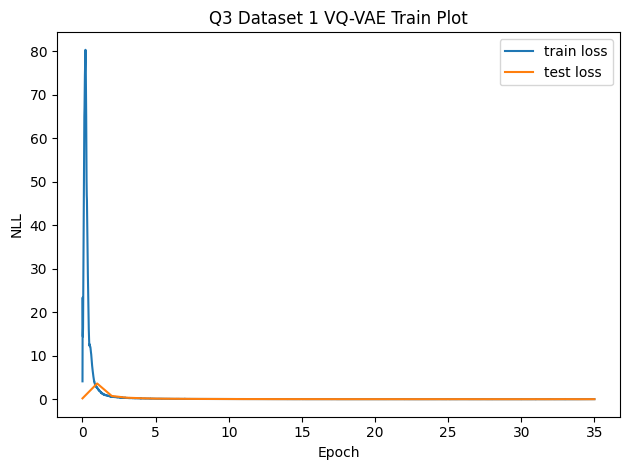

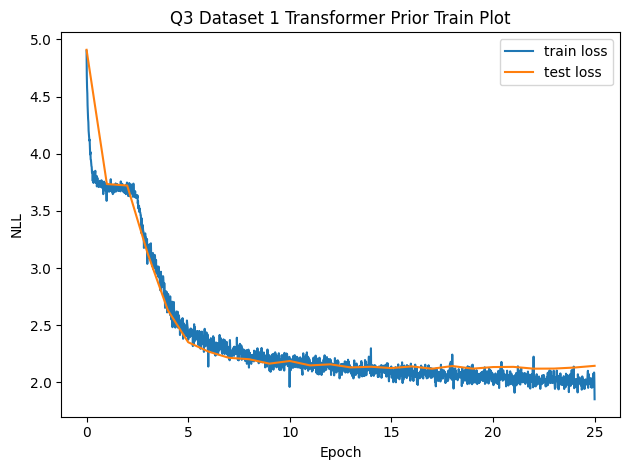

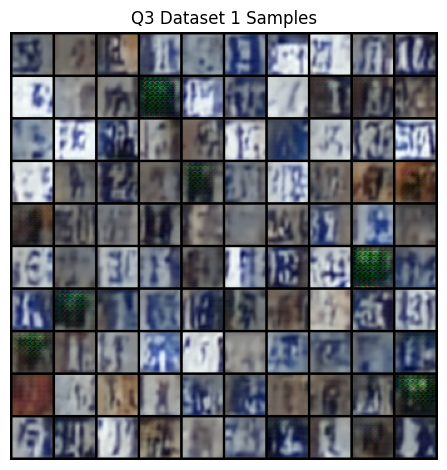

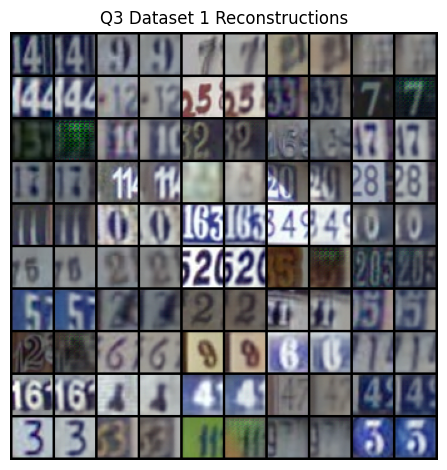

In [22]:
q3_save_results(1, q3)

In [ ]:
q3_save_results(2, q3)

# File Saving Utility


In [ ]:
# one way to save files
from google.colab import files
import os
import os.path as osp
for fname in os.listdir('results'):
    files.download('results/' + fname)